# User Behavior Analysis

In [1]:
import pandas as pd
import json
from tqdm import tqdm
from SPARQLWrapper import SPARQLWrapper, JSON
import time

MIND_type = 'MINDsmall'

data_path_base="/app/datasets/"
data_path = data_path_base + MIND_type +"/"


behaviors_file = data_path + "train/behaviors.tsv"
print(f"Behaviors File {behaviors_file}")

news_file = data_path + "train/news.tsv"
news_df = pd.read_csv(news_file, sep="\t", names=["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"])
print(f"News file {news_file}")
# Load the behaviors data
columns = ["impression_id", "user_id", "time", "history", "impressions"]
behaviors_df = pd.read_csv(behaviors_file, sep="\t", names=columns)

# Display basic statistics and data sample
#print(behaviors_df.info())
#print(behaviors_df.head())

Behaviors File /app/datasets/MINDsmall/train/behaviors.tsv
News file /app/datasets/MINDsmall/train/news.tsv


## Statistics

Calculate some statistics

**Number of unique users**: There are 50,000 unique users in the *small* MIND dataset.
**NUmber of sessions**: A session represents a single instance where a user interacts with the platform, such as browsing news or clicking on articles.
**Average Session length**: A longer history provides more context for the recommendation system but can also increase computational complexity.
**Average Impressions per session**: Impressions are the total number of recommendations or articles displayed to a user.


In [2]:
num_users = behaviors_df["user_id"].nunique()
print(f"Number of unique users: {num_users}")


num_sessions = len(behaviors_df)
print(f"Number of sessions: {num_sessions}")

behaviors_df["history_length"] = behaviors_df["history"].fillna("").apply(lambda x: len(x.split(" ")))
avg_history_length = behaviors_df["history_length"].mean()
print(f"Average session length (history length): {avg_history_length:.2f}")

behaviors_df["num_impressions"] = behaviors_df["impressions"].apply(lambda x: len(x.split(" ")))
avg_impressions = behaviors_df["num_impressions"].mean()
print(f"Average impressions per session: {avg_impressions:.2f}")




def calculate_ctr(impressions):
    clicks = sum([1 for impression in impressions.split(" ") if impression.endswith("-1")])
    total = len(impressions.split(" "))
    return clicks / total if total > 0 else 0

behaviors_df["ctr"] = behaviors_df["impressions"].apply(calculate_ctr)
avg_ctr = behaviors_df["ctr"].mean()
print(f"Average CTR: {avg_ctr:.2%}")



Number of unique users: 50000
Number of sessions: 156965
Average session length (history length): 32.56
Average impressions per session: 37.23
Average CTR: 10.85%


## Group Users into catagories based on engagement

In [3]:
def user_engagement_group(ctr):
    if ctr > 0.75:
        return "Highly Engaged"
    elif ctr > 0.25:
        return "Moderately Engaged"
    else:
        return "Low Engagement"

user_ctr = behaviors_df.groupby("user_id")["ctr"].mean()
engagement_groups = user_ctr.apply(user_engagement_group)

engagement_summary = engagement_groups.value_counts()
print("User Engagement Summary:")
print(engagement_summary)


User Engagement Summary:
ctr
Low Engagement        44627
Moderately Engaged     5373
Name: count, dtype: int64


## Based on time



<Axes: title={'center': 'CTR by Hour of Day'}, xlabel='Hour', ylabel='CTR'>

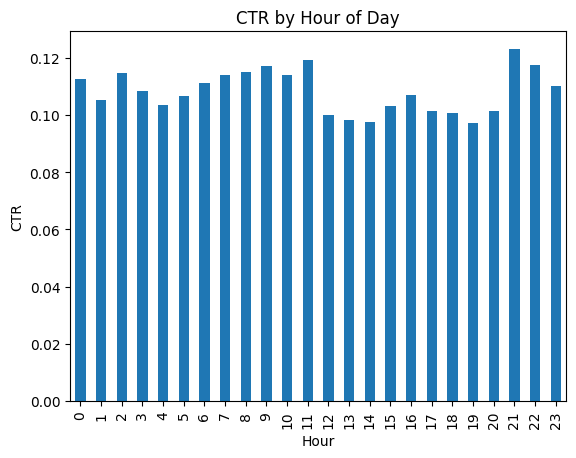

In [4]:
behaviors_df["time"] = pd.to_datetime(behaviors_df["time"])
behaviors_df["hour"] = behaviors_df["time"].dt.hour

hourly_behavior = behaviors_df.groupby("hour")["ctr"].mean()
hourly_behavior.plot(kind="bar", title="CTR by Hour of Day", xlabel="Hour", ylabel="CTR")


## Visualize the results


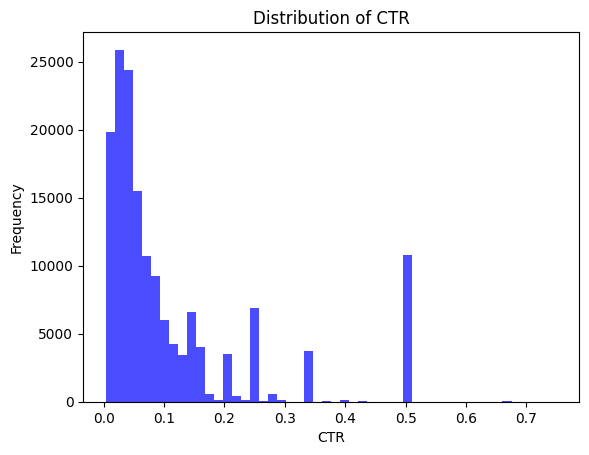

In [5]:
import matplotlib.pyplot as plt

plt.hist(behaviors_df["ctr"], bins=50, color="blue", alpha=0.7)
plt.title("Distribution of CTR")
plt.xlabel("CTR")
plt.ylabel("Frequency")
plt.show()


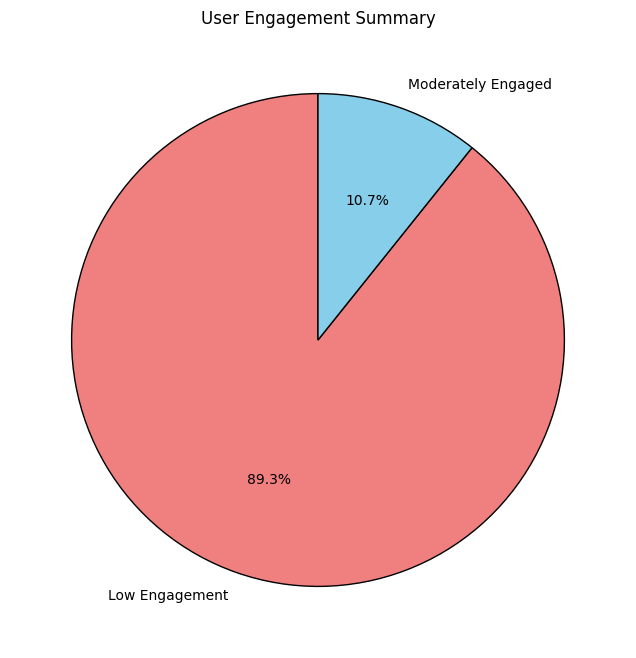

In [6]:
import matplotlib.pyplot as plt

# User engagement data
labels = ['Low Engagement', 'Moderately Engaged']
counts = [44627, 5373]
colors = ['lightcoral', 'skyblue']

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title('User Engagement Summary')
plt.show()


In [7]:
## Distribution of session history lengths


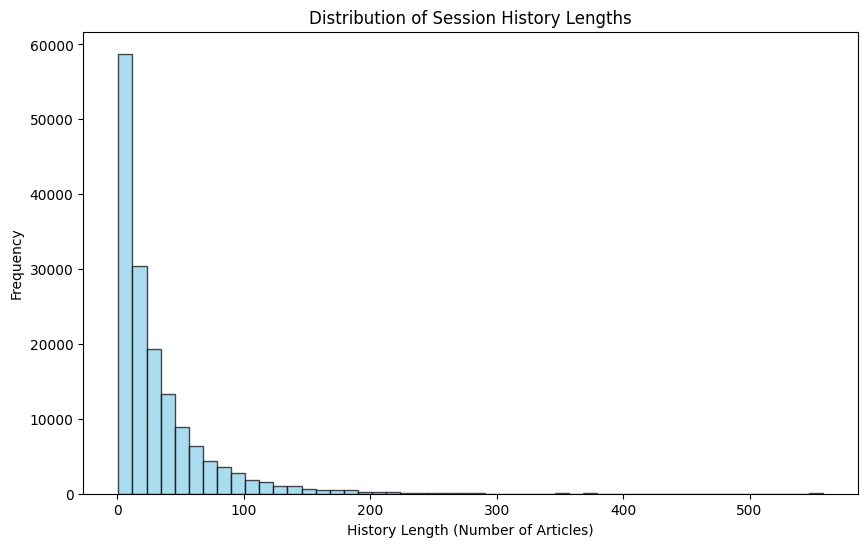

In [8]:
import matplotlib.pyplot as plt

# Distribution of session history lengths
plt.figure(figsize=(10, 6))
plt.hist(behaviors_df['history_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Session History Lengths')
plt.xlabel('History Length (Number of Articles)')
plt.ylabel('Frequency')
plt.show()


In [9]:
# Summary statistics for session history length
history_stats = behaviors_df['history_length'].describe()
print(history_stats)


count    156965.000000
mean         32.560615
std          40.251185
min           1.000000
25%           8.000000
50%          19.000000
75%          42.000000
max         558.000000
Name: history_length, dtype: float64


In [10]:
# Categorize sessions based on history length
def categorize_history_length(length):
    if length < 10:
        return 'Short'
    elif length < 50:
        return 'Medium'
    else:
        return 'Long'

behaviors_df['history_category'] = behaviors_df['history_length'].apply(categorize_history_length)

# Count sessions in each category
history_categories = behaviors_df['history_category'].value_counts()
print(history_categories)


history_category
Medium    78667
Short     46784
Long      31514
Name: count, dtype: int64


history_category
Long      0.096096
Medium    0.103968
Short     0.124624
Name: ctr, dtype: float64


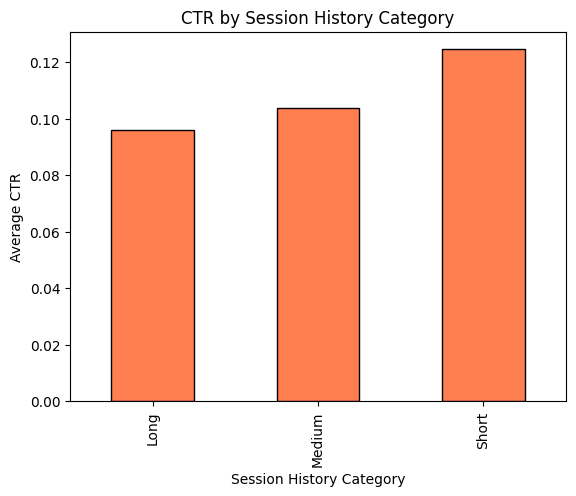

In [11]:
# Average CTR by history category
ctr_by_history_category = behaviors_df.groupby('history_category')['ctr'].mean()
print(ctr_by_history_category)

# Bar chart for visualization
ctr_by_history_category.plot(kind='bar', color='coral', edgecolor='black', title='CTR by Session History Category')
plt.xlabel('Session History Category')
plt.ylabel('Average CTR')
plt.show()


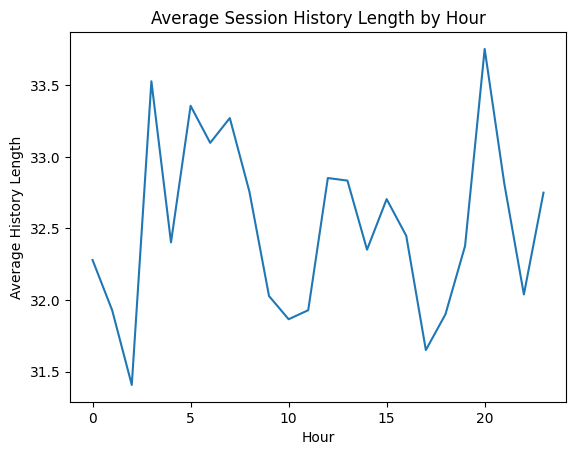

In [12]:
# Average history length by hour of the day
hourly_history = behaviors_df.groupby('hour')['history_length'].mean()
hourly_history.plot(kind='line', title='Average Session History Length by Hour', xlabel='Hour', ylabel='Average History Length')
plt.show()


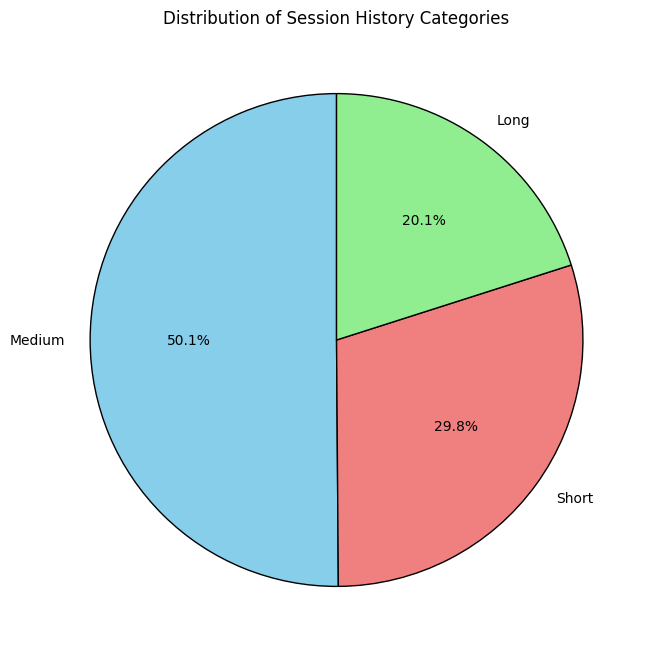

In [13]:
# Simulated data for 'history_category' counts
history_category_counts = {
    'Medium': 78667,
    'Short': 46784,
    'Long': 31514
}

# Pie chart for session history categories
plt.figure(figsize=(8, 8))
plt.pie(
    history_category_counts.values(),
    labels=history_category_counts.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightcoral', 'lightgreen'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Distribution of Session History Categories')
plt.show()


---

## Summary so Far

With the small MIND dataset we can see that most of the users are not engaged at all. 

There are 50,000 users and 156965 sesions. The majority of users, approximately 89% have low engagement suggesting either the recommendations are not aligning well with user interests or users are inherently less interactive and ignore recommendations, consumming news randomly.

## The Flip side

The flip side of this is that the user is drawn to recommendations because they are an expert in, say for example, *the Transylvania space program.* The recommendations are vital to focusing their attention on a specific area of analysis or research. 

## What would an analysts dataset look like

Consider a dataset of behaviors based on analysts who need to view the most `relevent news` first.  Not the daily news but the daily news about a specific topic that they maintain expertise on.  What does that look like?  How can we create that?



---

## First extract the entities/topics from the dataset

In [14]:

# Function to extract entity IDs
def extract_entity_ids(entities_str):
    if pd.isna(entities_str):
        return []
    entities = json.loads(entities_str)
    return [entity.get('WikidataId') for entity in entities if 'WikidataId' in entity]

# Extract entities from title and abstract as lists
news_df['title_entity_ids'] = news_df['title_entities'].apply(extract_entity_ids)
news_df['abstract_entity_ids'] = news_df['abstract_entities'].apply(extract_entity_ids)

# Combine all entity IDs into one column
news_df['all_entity_ids'] = news_df['title_entity_ids'] + news_df['abstract_entity_ids']

# Flatten and get unique entity IDs
unique_entity_ids = set(entity for entities in news_df['all_entity_ids'] for entity in entities)
print(f"Unique entity IDs: {len(unique_entity_ids)}")


Unique entity IDs: 27759


In [15]:
import requests

def fetch_entity_name_old(entity_id):
    url = f"https://www.wikidata.org/wiki/Special:EntityData/{entity_id}.json"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            return data['entities'][entity_id]['labels']['en']['value']
    except Exception as e:
        print(f"Error fetching {entity_id}: {e}")
    return "Unknown"

# Map IDs to names
#news_df['all_entity_names'] = news_df['all_entity_ids'].apply(lambda ids: [fetch_entity_name(eid) for eid in ids])


In [16]:

# Function to query Wikidata for entity names
def fetch_entity_name(entity_id):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    query = f"""
    SELECT ?entity ?label WHERE {{
      VALUES ?entity {{ wd:{entity_id} }}
      ?entity rdfs:label ?label .
      FILTER(LANG(?label) = "en")
    }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        for result in results['results']['bindings']:
            return result['label']['value']
    except Exception as e:
        print(f"Error fetching {entity_id}: {e}")
        return "Unknown"
